# ResNets

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'
plt.style.use('dark_background')

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
def test():
    x = torch.tensor(1.0, requires_grad=True)
    return x*2

In [ ]:
test()

tensor(2., grad_fn=<MulBackward0>)

In [ ]:
torch.no_grad()(test)()

tensor(2.)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#| export
# create relu activation with leak 0.1, sub 0.4
act_gr

In [ ]:
# multiclass accuracy
metrics 
# ActivationStats for general rely
astats 
# device, metrics, progress, stats
cbs 
# initialization for leaky 0.1
iw 

## Going deeper

Before our base model had 5 layers with filters [1,8,16,32,64]. As we are using now more sophisticated trickes (learning rate scheduler, AdamOptimizer, BN layers) we can now go deeper. We can build upon our previous architecture and increase number of filters up to 128. To do this we can set stride to 1 for the first convolutional layers in order to keep the height and width the same.

In [ ]:
??get_model

Signature:
get_model(
    act=<class 'torch.nn.modules.activation.ReLU'>,
    nfs=None,
    norm=None,
)
Docstring: <no docstring>
Source:   
def get_model(act=nn.ReLU, nfs=None, norm=None):
    # standard number of filters ([1,8,16,32,64])
    if nfs is None: nfs = [1,8,16,32,64]
    # conv layers for given filters
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    #  pull together with final layers without activation of normalization. Then flatten and move to device
    return nn.Sequential(*layers, conv(nfs[-1], 10,act=None, norm=False, bias=True), 
                         nn.Flatten()).to(def_device)
File:      /notebooks/fastai-p2/miniai/init.py
Type:      function


In [ ]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    # conv layer with stride 1 to get 8 filters
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    # add layers with standard stide and specified filters
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    # pool into sequential, add final conv layer without norm, with bias, flatten and move to device
    return nn.Sequential(*layers, 
                         conv(nfs[-1], 10, act=None, norm=None, bias=True), 
                         nn.Flatten()).to(def_device)

In [ ]:
len(dls.train)

59

In [ ]:
set_seed(42)
lr, epochs = 6e-2, 5
model = 
# number of steps for schedulers
tmax = 
# OneCycleLR scheduler
sched = 
# BatchSchedCB
xtra =
# use AdamW
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.806,0.535,0,train
0.840,0.558,0,eval
0.869,0.367,1,train
0.842,0.456,1,eval
0.901,0.268,2,train
0.900,0.286,2,eval
0.924,0.206,3,train
0.911,0.244,3,eval
0.942,0.160,4,train
0.916,0.232,4,eval


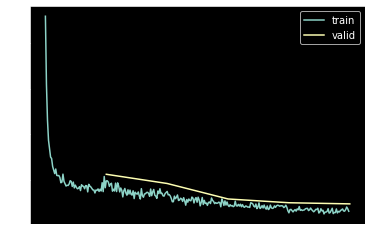

In [ ]:
learn.fit(epochs)

## Skip Connections 

The ResNet (_residual network_) was introduced in 2015 by Kaiming He et al in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385). The key idea is using a skip connection to allow deeper networks to train successfully.

![""](https://raw.githubusercontent.com/Iamalos/course22p2/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/images/att_00042.png)

50 layer NN is a superset of a 20 layer NN so it should be at least as good. But in practice it is often not - it is worse. That means there is some problem during training of a net.

The basic idea is `out = conv2(conv1(in)) + in`. But this only works if we can add those together. If `conv2` and `conv1` has the same number of filters as `in` and they have stride 1, than shapes will be the same and we can add them together. If not, than we need to add a conv on `in` just to make `in` compatable with conv layer. We call it `identity conv`.

Below we first create a _conv_block for `conv2(conv1(in))`. Conv1 has a stride of one and is used to adjust number of channels without changing height and width.

In [ ]:
#| export 
# conv_block if conv2(conv1(in)). for conv2 don't use activation
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    # if norm: init.constant_(conv2[1].weight, 0.)
    # return sequential with two convs
    return 

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        # create `self.convs` conv2(conv1(in))
        
        # create `idconv` if ni and nf filters are not equal. 
        # Use minimum efforts (ks and stride are 1). If equal, noop
       
        # if stride is not 1 (but 2) use Average pool, else noop
        
        # apply activation
        
    # in forward add con layer + initial layer in id and pool. Apply activation
    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))  

Jeremy discovered that initializing the `conv2` batchnorm weights to zero makes things worse in every model they tried, so they removed that. That init method was originally introduced to handle training extremely deep models (much deeper than we use here) -- it appears from this little test that it might be worse for less deep models

Now let's change our get_model function to use residual blocks

In [ ]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    # first layer with stride 1 to keep width and height
    layers = 
    # all intermediate layers
    layers += 
    # flatter, final linear and BN1d
    layers += 
    # put layers together into Sequential and move to device
    return 

ask GPT about the difference in BN1d and BN2d

In [ ]:
# inp is (x,y) tuple
def _print_shape(hook, mod, inp, outp): 
    # print tyope name an input and output shapes

model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
# with Hooks fit


ResBlock torch.Size([2048, 1, 28, 28]) torch.Size([2048, 8, 28, 28])
ResBlock torch.Size([2048, 8, 28, 28]) torch.Size([2048, 16, 14, 14])
ResBlock torch.Size([2048, 16, 14, 14]) torch.Size([2048, 32, 7, 7])
ResBlock torch.Size([2048, 32, 7, 7]) torch.Size([2048, 64, 4, 4])
ResBlock torch.Size([2048, 64, 4, 4]) torch.Size([2048, 128, 2, 2])
ResBlock torch.Size([2048, 128, 2, 2]) torch.Size([2048, 256, 1, 1])
Flatten torch.Size([2048, 256, 1, 1]) torch.Size([2048, 256])
Linear torch.Size([2048, 256]) torch.Size([2048, 10])
BatchNorm1d torch.Size([2048, 10]) torch.Size([2048, 10])


We can improve the vizualization and use HTML to show a nice table.

The `nonlocal` keyword is used to work with variables inside nested functions, where the variable should not belong to the inner function. Think about the function below.

In [ ]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
   
    def _f(hook, mod, inp, outp):
        # use nonlocal res and tot
        nonlocal res, tot
        # get `nparams` and update tot and res
       
    # with Hooks fit using SingleBatchCB and train False. lr=1
    
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [ ]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1228908


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
|ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
|ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
|ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
|ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
|ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
|Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
|Linear|(2048, 256)|(2048, 10)|2560|
|BatchNorm1d|(2048, 10)|(2048, 10)|20|


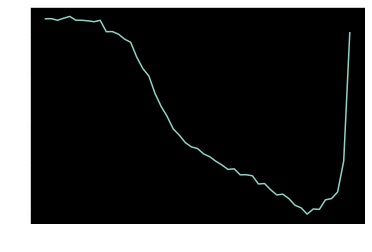

In [ ]:
# get model and use lr_find with MomentumLearner
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [ ]:
lr = 2e-2
tmax = 
# OneCycleLR
sched = 
# BatchSched
xtra = 
model =
# AdamW
learn = 

accuracy,loss,epoch,train
0.815,0.714,0,train
0.859,0.480,0,eval
0.891,0.352,1,train
0.872,0.384,1,eval
0.915,0.257,2,train
0.914,0.259,2,eval
0.935,0.196,3,train
0.918,0.231,3,eval
0.952,0.149,4,train
0.929,0.208,4,eval


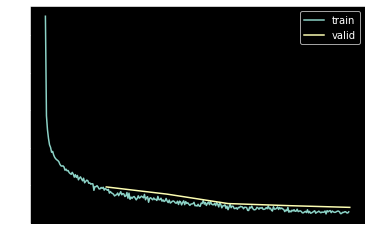

In [ ]:
learn.fit(epochs)

In [ ]:
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck

In [ ]:
' '.join(timm.list_models('*resnet*'))

'cspresnet50 cspresnet50d cspresnet50w eca_resnet33ts ecaresnet26t ecaresnet50d ecaresnet50d_pruned ecaresnet50t ecaresnet101d ecaresnet101d_pruned ecaresnet200d ecaresnet269d ecaresnetlight gcresnet33ts gcresnet50t inception_resnet_v2 lambda_resnet26rpt_256 lambda_resnet26t lambda_resnet50ts legacy_seresnet18 legacy_seresnet34 legacy_seresnet50 legacy_seresnet101 legacy_seresnet152 nf_ecaresnet26 nf_ecaresnet50 nf_ecaresnet101 nf_resnet26 nf_resnet50 nf_resnet101 nf_seresnet26 nf_seresnet50 nf_seresnet101 resnet10t resnet14t resnet18 resnet18d resnet26 resnet26d resnet26t resnet32ts resnet33ts resnet34 resnet34d resnet50 resnet50_gn resnet50c resnet50d resnet50s resnet50t resnet51q resnet61q resnet101 resnet101c resnet101d resnet101s resnet152 resnet152c resnet152d resnet152s resnet200 resnet200d resnetaa34d resnetaa50 resnetaa50d resnetaa101d resnetblur18 resnetblur50 resnetblur50d resnetblur101d resnetrs50 resnetrs101 resnetrs152 resnetrs200 resnetrs270 resnetrs350 resnetrs420 resne

In [ ]:
model = timm.create_model('resnet18d', in_chans=1, num_classes=10)
# model = ResNet(in_chans=1, block=BasicBlock, layers=[2,2,2,2], stem_width=32, avg_down=True)     

In [ ]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.781,0.630,0,train
0.738,1.041,0,eval
0.876,0.330,1,train
0.787,0.767,1,eval
0.907,0.251,2,train
0.891,0.300,2,eval
0.927,0.192,3,train
0.911,0.246,3,eval
0.946,0.145,4,train
0.918,0.227,4,eval


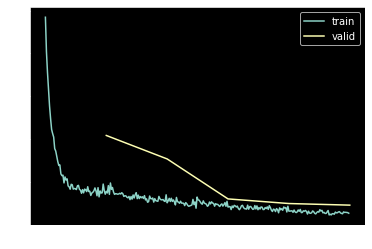

In [ ]:
learn.fit(epochs)